In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/vuyis/Downloads/Amazon Sale Report.csv/spaza_shop_sales.csv")


In [3]:
# Data Preparation
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds', 'sales': 'y'})
df = df.sort_values(by='ds')


In [23]:
# Print missing values before handling
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
ds    0
y     0
dtype: int64


In [24]:
# Handle missing values
df = df.dropna()

In [25]:
# Verify that missing values have been handled
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
ds    0
y     0
dtype: int64


In [87]:
def fit_and_plot_prophet(df):
    # Prepare Prophet DataFrame
    prophet_df = df[['ds', 'y']]
    model_prophet = Prophet()
    
    # Add holidays and seasonality
    model_prophet.add_country_holidays(country_name='ZA')
    model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=8)
    

In [88]:
# LSTM Model
# Prepare data for LSTM
data = df.set_index('ds')['y']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

In [89]:
# Convert to PyTorch tensors
scaled_data = torch.FloatTensor(scaled_data).view(-1)

In [90]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

n_input = 10
X, y = create_sequences(scaled_data, n_input)


In [91]:
# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [92]:
# Create DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [93]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [94]:
# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [95]:
# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.unsqueeze(-1)  # Add feature dimension
        batch_y = batch_y.unsqueeze(-1)  # Add feature dimension
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.1446
Epoch [2/50], Loss: 0.2127
Epoch [3/50], Loss: 0.2302
Epoch [4/50], Loss: 0.1680
Epoch [5/50], Loss: 0.1281
Epoch [6/50], Loss: 0.1002
Epoch [7/50], Loss: 0.0765
Epoch [8/50], Loss: 0.0529
Epoch [9/50], Loss: 0.0324
Epoch [10/50], Loss: 0.0612
Epoch [11/50], Loss: 0.0748
Epoch [12/50], Loss: 0.0328
Epoch [13/50], Loss: 0.0622
Epoch [14/50], Loss: 0.0220
Epoch [15/50], Loss: 0.0199
Epoch [16/50], Loss: 0.0314
Epoch [17/50], Loss: 0.0397
Epoch [18/50], Loss: 0.0225
Epoch [19/50], Loss: 0.0478
Epoch [20/50], Loss: 0.0107
Epoch [21/50], Loss: 0.0209
Epoch [22/50], Loss: 0.0151
Epoch [23/50], Loss: 0.0209
Epoch [24/50], Loss: 0.0299
Epoch [25/50], Loss: 0.0307
Epoch [26/50], Loss: 0.0287
Epoch [27/50], Loss: 0.0137
Epoch [28/50], Loss: 0.0108
Epoch [29/50], Loss: 0.0213
Epoch [30/50], Loss: 0.0172
Epoch [31/50], Loss: 0.0256
Epoch [32/50], Loss: 0.0251
Epoch [33/50], Loss: 0.0131
Epoch [34/50], Loss: 0.0228
Epoch [35/50], Loss: 0.0031
Epoch [36/50], Loss: 0.0190
E

In [96]:
# Make predictions
model.eval()
with torch.no_grad():
    predictions = []
    for batch_x, _ in test_loader:
        batch_x = batch_x.unsqueeze(-1)
        outputs = model(batch_x)
        predictions.extend(outputs.squeeze().tolist())


In [97]:
# Rescale predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [98]:
# Prepare data for plotting
test_dates = df['ds'].iloc[len(df) - len(predictions):].reset_index(drop=True)
actual_values = df['y'].iloc[len(df) - len(predictions):].reset_index(drop=True)


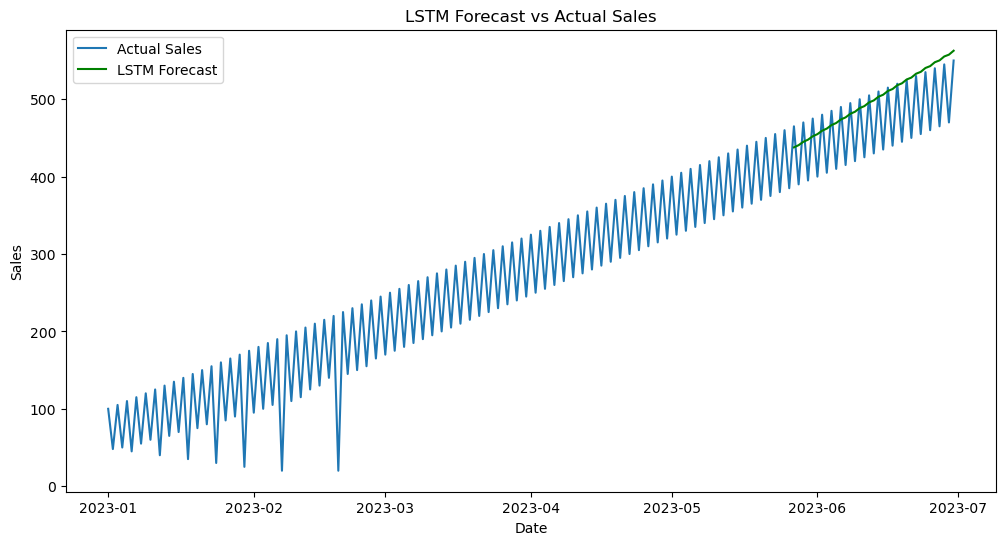

In [99]:
# Plot results for LSTM
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Sales')
plt.plot(test_dates, predictions, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

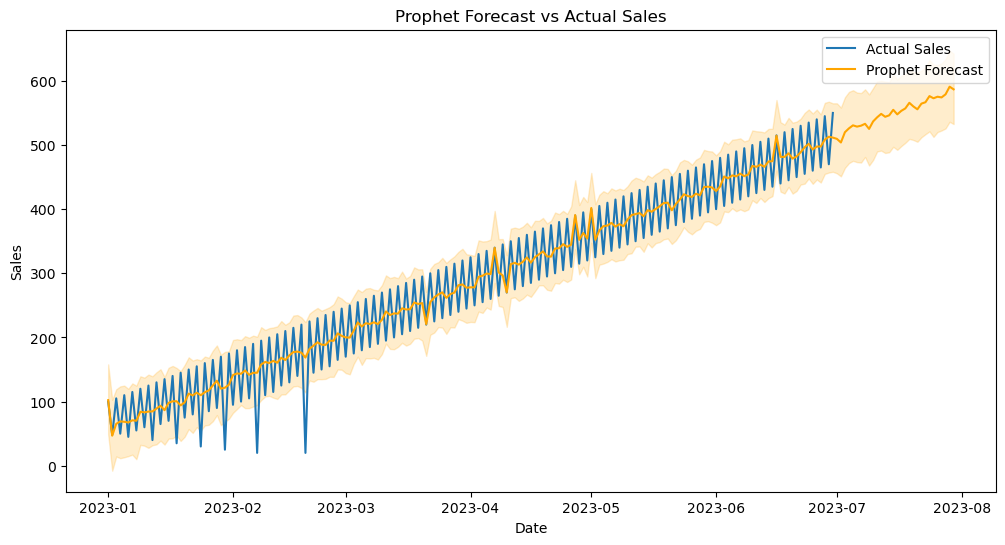

In [101]:
# Visualization of Prophet forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Sales')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='orange')
plt.fill_between(forecast_prophet['ds'], forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color='orange', alpha=0.2)

plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


# Visualization of ARIMA forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Sales')
future_dates = pd.date_range(start=df['ds'].max(), periods=31, freq='D')[1:]
plt.plot(future_dates, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [21]:
# Comparison and Insights
# Prophet: Takes into account trend and seasonality, handles holidays and special events.
# ARIMA: Focuses on autocorrelation, needs data to be stationary, good for short-term forecasting.
# LSTM: Captures long-term dependencies, useful for complex patterns but requires substantial data and computational resources.

print("Model Comparison and Insights:")
print("1. Prophet handles trend and seasonality well, including holiday effects. It is user-friendly and easy to interpret.")
print("2. ARIMA is good for time series with autocorrelation. It requires stationary data and might not perform well with complex patterns.")
print("3. LSTM is powerful for capturing long-term dependencies and complex patterns but requires a large amount of data and can be computationally intensive.")


Model Comparison and Insights:
1. Prophet handles trend and seasonality well, including holiday effects. It is user-friendly and easy to interpret.
2. ARIMA is good for time series with autocorrelation. It requires stationary data and might not perform well with complex patterns.
3. LSTM is powerful for capturing long-term dependencies and complex patterns but requires a large amount of data and can be computationally intensive.


In [22]:
# Recommendations for spaza shop owners
print("Recommendations:")
print("1. Use Prophet to forecast sales trends and seasonality, especially if your business experiences significant seasonal effects or holidays.")
print("2. ARIMA can be useful for short-term forecasts if your sales data shows strong autocorrelation patterns.")
print("3. LSTM can be considered for more complex and long-term forecasts but ensure you have enough data and computational resources.")


Recommendations:
1. Use Prophet to forecast sales trends and seasonality, especially if your business experiences significant seasonal effects or holidays.
2. ARIMA can be useful for short-term forecasts if your sales data shows strong autocorrelation patterns.
3. LSTM can be considered for more complex and long-term forecasts but ensure you have enough data and computational resources.
